# Part 1: Data Preprocessing

In this part of the tutorials, you will be guided through the different parsing steps needed to ensure high-quality consistent data formats. <br>
<br>
This includes: 
- Loading the data
- Remove entries with missing data
- Remove CDR3β sequences containing non-amino acid characters
- Remove CDR3β sequences not starting/ending with the conserved cysteine (C) and end with a phenylalanine (F) residue
- Merging and excluding duplicate sequences from the data


In [1]:
# Install pyteomics package if not installed already
!pip install pyteomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import necessary packages

import pandas as pd

from pyteomics import parser

In [3]:
# Load the data using the 'Upload to session storage' button on the left 
# Upload both the P1_0.tsv file and P1_15.tsv file

# Read in the correct data files for the patient at different time points (day 0 and day 15)
Patient_pre = pd.read_csv('P1_0.tsv', sep='\t')
Patient_post = pd.read_csv('P1_15.tsv', sep='\t')

In [4]:
# Show an example of how the data looks like
Patient_pre

,v_call,j_call,junction_aa,duplicate_count,frequency
0,TRBV6-2,TRBJ2-1,CASSNSDRTYGDNEQFF,33422.0,1.250358e-02
1,TRBV24-1,TRBJ2-5,CATSSVLTQQETQYF,24502.0,9.166497e-03
2,TRBV12-3,TRBJ2-3,CASSSRGLANTQYF,22361.0,8.365523e-03
3,TRBV29-1,TRBJ2-7,CSVVGADTYEQYF,20930.0,7.830168e-03
4,TRBV7-8,TRBJ1-1,CASSLGTALNTEAFF,20193.0,7.554447e-03
...,...,...,...,...,...
325239,TRBV27,TRBJ2-4,CASSPLTGPAEAKNIQYF,1.0,3.741122e-07
325240,TRBV27,TRBJ2-4,CASSPLSSGGPKNIQYF,1.0,3.741122e-07
325241,TRBV27,TRBJ2-4,CASSPLREGLAKNIQYF,1.0,3.741122e-07
325242,TRBV5-1,TRBJ1-1,CASSLRAGVNTEAFF,1.0,3.741122e-07


In [5]:
# Define all standard amino acids
def is_amino_acid(cdr3):
    # Check if all amino acids in CDR3 sequence are standard amino acids
    # (i.e., they are present in the pyteomics parser's list of standard amino acids)
    return all(aa in parser.std_amino_acids for aa in cdr3)

# Define parsing function
def parse_data(dataframe):

    # Select only the sequences with known amino acids
    # (i.e., sequences that only contain standard amino acids)
    aa_parser = dataframe[dataframe['junction_aa'].apply(is_amino_acid)]

    # Make sure each sequence starts with C and ends with F
    start_c = aa_parser['junction_aa'].str.startswith('C', na=False)
    end_f = aa_parser['junction_aa'].str.endswith('F', na=False)
    parse_result = aa_parser[start_c & end_f].reset_index(drop=True)

    # Sum the clone counts for duplicate TCRs and merge into one entry
    parse_result['Total_count'] = parse_result.groupby(['junction_aa','v_call','j_call'])['duplicate_count'].transform('sum')
    parse_result['Total_frequency'] = parse_result.groupby(['junction_aa','v_call','j_call'])['frequency'].transform('sum')
    parse_result = parse_result[['junction_aa', 'v_call', 'j_call', 'Total_count', 'Total_frequency']]
    parse_result.drop_duplicates(subset=['junction_aa', 'v_call', 'j_call'], inplace=True)

    return parse_result


# Define a function to apply column extraction and data parsing on the dataframe
def full_parsing(data):
    Parsing = parse_data(data)

    # Show the number of TCRs before and after parsing, as well as the number of TCRs removed
    print(f'The number of TCRs before parsing is: {len(data)}')
    print(f'The number of TCRs after parsing is: {len(Parsing)}')
    print(f'The number of TCRs removed is : {len(data) - len(Parsing)}')

    # Show the exact sequences that have been removed
    Before = data['junction_aa']
    After = Parsing['junction_aa']
    print(f'The removed sequences are : {set(Before)-set(After)} \n')

    return Parsing

In [6]:
# Perform the parsing functions define above
# For both the repertoire at day 0 and at day 15
print('Repertoire at day 0:')
Pre_parsed = full_parsing(Patient_pre)

print('Repertoire at day 15:')
Post_parsed = full_parsing(Patient_post)

Repertoire at day 0:
The number of TCRs before parsing is: 325244
The number of TCRs after parsing is: 325242
The number of TCRs removed is : 2
The removed sequences are : {'CADSLAGGW', 'CASGPMSGPFW'} 

Repertoire at day 15:
The number of TCRs before parsing is: 292655
The number of TCRs after parsing is: 292653
The number of TCRs removed is : 2
The removed sequences are : {'CASSYPGAGDEW', 'CSASSSW'} 



In [7]:
# Remove CDR3 duplicates for clustering
# Based only on the CDR3 sequence
Pre_clustcr = Pre_parsed.drop_duplicates(subset=['junction_aa'])
Post_clustcr = Post_parsed.drop_duplicates(subset=['junction_aa'])

# Save these parsed repertoires as a tsv file for later usage with clusTCR
Pre_clustcr.to_csv('P1_0_parsed.tsv', sep='\t')
Post_clustcr.to_csv('P1_15_parsed.tsv', sep='\t')

# Part 2: Repertoire richness and diversity calculations

For this section of the tutorials, the use of scikit-bio for repertoire diversity calculations will be illustrated. <br>
In addition, this notebook shows you how to calculate repertoire richness and overlap between different repertoires. <br>

### Diversity calculations:
- Repertoire richness
- Shannon diversity
- Pielou's evenness
- Simpson and Gini-Simpson diversity
- Gini coefficient
- DE50

In [8]:
# Install the package needed for the diversity calculations
# More info regarding scikit-bio and its possibilities can be foudn here:
# http://scikit-bio.org

!pip install scikit-bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 35.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.7 MB/s eta 0:00:00
  Created wheel for scikit-bio: filename=scikit_bio-0.5.8-cp39-cp39-linux_x86_64.whl size=2723619 sha256=f3aa58222169ab3f390a8231bacb0710a26045f3757d5a1cf415eb3464204a10
  Stored in directory: /root/.cache/pip/wheels/88/2c/59/1aa91558b7623567364d73fc46b3e74055aac2d852c45e0048
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp39-cp39-linux_x86_64.whl size=677832 sha256=0b59dbe9a619a7565fc5f9f797439ae0a469e754feb220b355

In [9]:
# Import necessary packages

import matplotlib.pyplot as plt

import pandas as pd

from skbio.diversity.alpha import shannon, gini_index, pielou_e, simpson

In [10]:
# Show the data we will use as input for these calculations
# The two parsed dataframes from the previous step
Post_parsed

,junction_aa,v_call,j_call,Total_count,Total_frequency
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,14403.0,7.918540e-03
1,CASSRRHLGNTGELFF,TRBV7-2,TRBJ2-2,11651.0,6.405534e-03
2,CASSPSTDTQYF,TRBV27,TRBJ2-3,10538.0,5.793624e-03
3,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,10238.0,5.628689e-03
4,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,10156.0,5.583607e-03
...,...,...,...,...,...
292648,CASTPTGSYEQYF,TRBV6-1,TRBJ2-7,1.0,5.497840e-07
292649,CASTPSGTDSYEQYF,TRBV6-1,TRBJ2-7,1.0,5.497840e-07
292650,CASTPPGQGGYEQYF,TRBV6-1,TRBJ2-7,1.0,5.497840e-07
292651,CASSVGLAGVYEQYF,TRBV2,TRBJ2-7,1.0,5.497840e-07


In [11]:
# Define calculations for 50th percentile diversity

def get_50th_percentile(data):
    # Sort the data from high to low clonal frequency
    data.sort_values(by='Total_frequency', ascending=False)

    # Calculate the cummulative frequency per sequence
    data['cumulative_sum'] = data['Total_frequency'].cumsum()

    # Identify the number of clones needed to reach the threshold value
    First_index = data[data.cumulative_sum >= 0.5].index[0]
    Ratio = First_index/len(data)
    return Ratio

In [12]:
# Calculate all diversity metrics and combine results in a single dataframe
Dataframes = [Pre_parsed, Post_parsed]
Patients = ['Pre', 'Post']
Df = []

for i, j in zip(Dataframes, Patients):

    # Set patient identifier, in this case pre- and post-vaccination
    Patient_id = j

    # Calculate richness = the number of unique TCR sequences in the repertoire
    Richness = len(i)

    # Calculate several diversity metrics using scikit-bio
    Shannon = shannon(i['Total_frequency'], base=2)
    Pielou = pielou_e(i['Total_frequency'])
    Simpson = simpson(i['Total_frequency'])
    Gini = gini_index(i['Total_frequency'])

    # Calculate the DE50 value using the funtion created above
    DE50 = get_50th_percentile(i)

    # Combine all results in a comprehensive dataframe
    df = pd.DataFrame({
        'Patient_id': [Patient_id],
        'Richness': [Richness],
        'Shannon_index': [Shannon],
        'Pielou_evenness': [Pielou],
        'Gini-Simpson': [Simpson],
        'DE50': [DE50],
        'Gini_coefficient': [Gini]})
    Df.append(df)

Result_df = pd.concat(Df)
Result_df.reset_index(drop=True, inplace=True)
Result_df

,Patient_id,Richness,Shannon_index,Pielou_evenness,Gini-Simpson,DE50,Gini_coefficient
0,Pre,325242,4.172840,0.227885,0.375488,0.128763,0.904281
1,Post,292653,16.188821,0.891512,0.999574,0.101889,0.581509


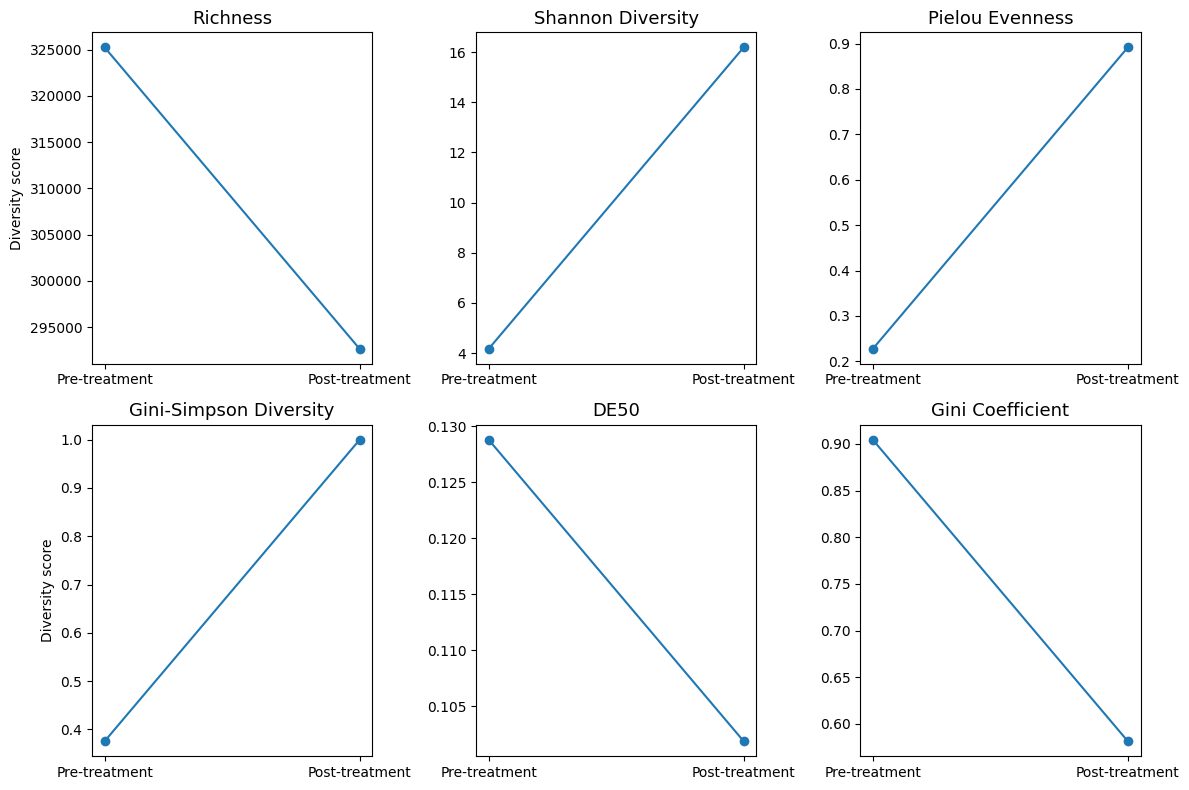

In [19]:
# Import necessary packages
import matplotlib.pyplot as plt

# Set x-axis values and select data
x = ['Pre-treatment', 'Post-treatment']
Richness = [Result_df.iloc[0,1], Result_df.iloc[1,1]]
Shannon = [Result_df.iloc[0,2], Result_df.iloc[1,2]]
Pielou = [Result_df.iloc[0,3], Result_df.iloc[1,3]]
Gini_Simpson = [Result_df.iloc[0,4], Result_df.iloc[1,4]]
DE50 = [Result_df.iloc[0,5], Result_df.iloc[1,5]]
Gini = [Result_df.iloc[0,6], Result_df.iloc[1,6]]

# Set up figure and axes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot Richness
axs[0, 0].plot(x, Richness, linestyle="-", marker="o", label="Richness")
axs[0, 0].set_title('Richness', fontsize=13)
axs[0, 0].set_ylabel('Diversity score', fontsize=10)

# Plot Shannon diversity
axs[0, 1].plot(x, Shannon, linestyle="-", marker="o", label="Shannon Diversity")
axs[0, 1].set_title('Shannon Diversity', fontsize=13)

# Plot Pielou evenness
axs[0, 2].plot(x, Pielou, linestyle="-", marker="o", label="Pielou Evenness")
axs[0, 2].set_title('Pielou Evenness', fontsize=13)

# Plot Gini-Simpson diversity
axs[1, 0].plot(x, Gini_Simpson, linestyle="-", marker="o", label="Gini-Simpson Diversity")
axs[1, 0].set_title('Gini-Simpson Diversity', fontsize=13)
axs[1, 0].set_ylabel('Diversity score', fontsize=10)

# Plot DE50
axs[1, 1].plot(x, DE50, linestyle="-", marker="o", label="DE50")
axs[1, 1].set_title('DE50', fontsize=13)

# Plot Gini coefficient
axs[1, 2].plot(x, Gini, linestyle="-", marker="o", label="Gini Coefficient")
axs[1, 2].set_title('Gini Coefficient', fontsize=13)

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('Diversity_metrics.jpg', dpi=400)


In [14]:
# Example using pre- and post-treatment repertoires of three cancer patients with immunotherapy
# Load the patient_comparison_data.csv file to explore diversity metrics between different people
Example_data = pd.read_csv('Patient_comparison_data.csv', index_col=[0])
Example_data


,Patient_id,Richness,Shannon_index,Pielou_evenness,Gini-Simpson,DE50,Gini_coefficient
0,P1_pre,15074,11.236565,0.809564,0.996644,0.054597,0.715936
1,P1_post,2720,7.902048,0.692592,0.936423,0.036765,0.730809
2,P2_pre,17976,10.256699,0.725687,0.987401,0.032655,0.802038
3,P2_post,39808,11.560222,0.756521,0.995896,0.026678,0.817275
4,P3_pre,11584,12.273467,0.909156,0.998595,0.356095,0.466271
5,P3_post,46629,11.076526,0.714203,0.995098,0.011066,0.852803


In [15]:
# Define a function to plot each diversity metric for three patients in the same plot
def get_metric_plots(dataframe, metric_index, title, ax):

    # Set x-axis values and select data
    x = ['Pre-treatment', 'Post-treatment']
    Pat1_m = [dataframe.iloc[0,metric_index], dataframe.iloc[1,metric_index]]
    Pat2_m = [dataframe.iloc[2,metric_index], dataframe.iloc[3,metric_index]]
    Pat3_m = [dataframe.iloc[4,metric_index], dataframe.iloc[5,metric_index]]

    # Plot the figure on the specified axes
    ax.plot(x, Pat1_m, linestyle="-", marker="o", label="Patient 1")
    ax.plot(x, Pat2_m, linestyle="-", marker="o", label="Patient 2")
    ax.plot(x, Pat3_m, linestyle="-", marker="o", label="Patient 3")
    ax.set_title(f'{title}', fontsize=13)
    ax.set_ylabel(f'{title} score', fontsize=10)

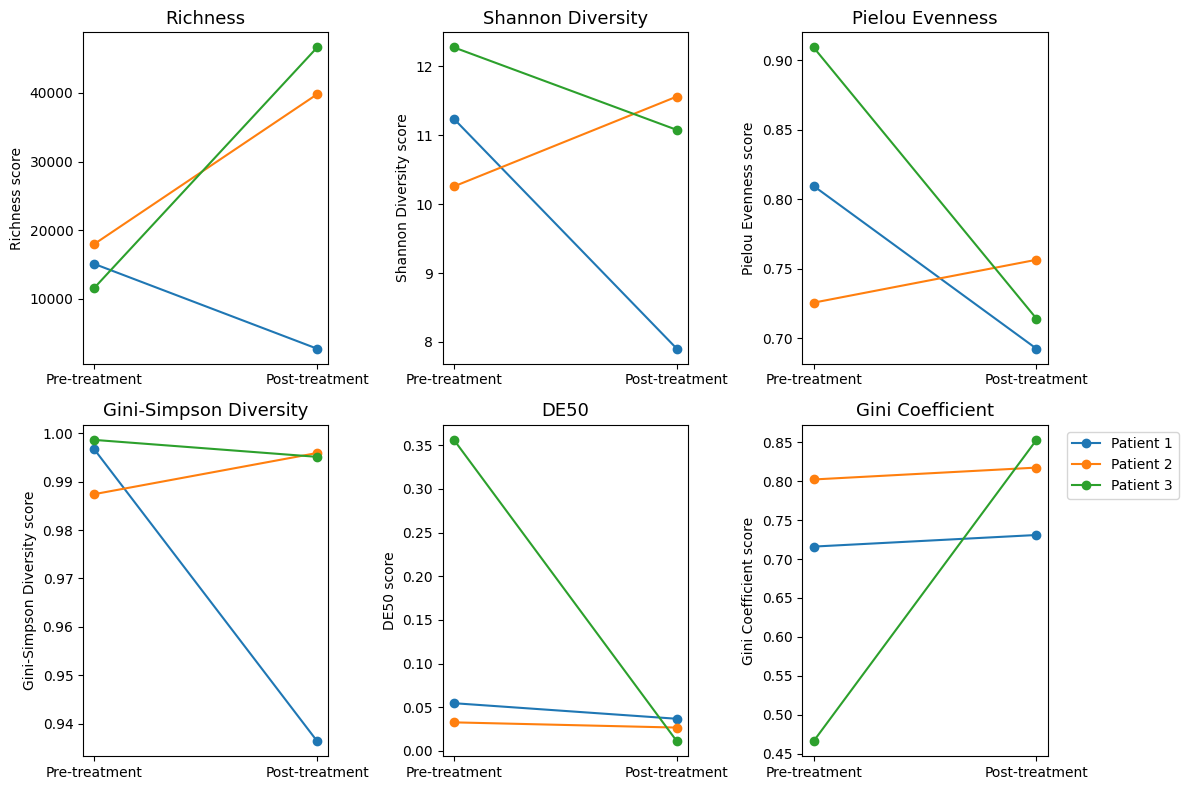

In [17]:
# Set up figure and axes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Set x-axis values and select data
x = ['Pre-treatment', 'Post-treatment']
metrics = ['Richness', 'Shannon Diversity', 'Pielou Evenness', 'Gini-Simpson Diversity', 'DE50', 'Gini Coefficient']
metric_indices = [1, 2, 3, 4, 5, 6]

# Plot each metric on a separate subplot
for i in range(len(metrics)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    metric = metrics[i]
    metric_index = metric_indices[i]
    get_metric_plots(Example_data, metric_index, metric, ax)

# Add legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig('Diversity_comparison.jpg', dpi=400)

In [20]:
# Define Jaccard and Morisita repertoire ovelap calculations

def get_repertoire_overlap(data_pre, data_post):

    # Merge both repertoires and discover which TCR sequences are present in both repertoires
    overlap = data_pre.merge(data_post, how='inner', on=['junction_aa', 'v_call', 'j_call'], suffixes=['_pre','_post'])
    
    return overlap


def get_jaccard_index(data_pre, data_post):

    # Get the number of overlapping clones based on the full CDR3 sequence
    Cij = len(data_pre.merge(data_post, how='inner', on=['junction_aa', 'v_call', 'j_call']))

    # Get the total number of unique clones in each repertoire
    Ni = len(data_pre)
    Nj = len(data_post)

    # Calculate Jaccard index
    Jaccard = (Cij)/(Ni+Nj-Cij)

    return Jaccard


def get_morisita_index(data_pre, data_post):
    
    # Get the total clone counts in the repertoires 
    n1 = data_pre['Total_count'].sum()
    n2 = data_post['Total_count'].sum()
    
    # Calculate clone count frequency of every TCR in the repertoires (i.e. N1i/N1 and N2i/N2)
    data_pre['Clone_frequency']=data_pre['Total_count']/n1
    data_post['Clone_frequency']=data_post['Total_count']/n2
    
    # Get public TCRs
    public = data_pre.merge(data_post, how='inner', on=['junction_aa', 'v_call', 'j_call'], suffixes=['_1','_2'])
    
    # Calculate product of clone count for every public TCR
    public['N1iN2i'] = public['Total_count_1']*public['Total_count_2']
    
    # Calculate morisita index
    numerator = 2*(public['N1iN2i'].sum())
    denominator = (public['Clone_frequency_1'].sum() + public['Clone_frequency_2'].sum())*n1*n2
    morisita_index = numerator/denominator
    
    return morisita_index

In [21]:
# Get the number of TCR sequences that are present in both the pre- and post-vaccination repertoire
Overlap = get_repertoire_overlap(Pre_parsed,Post_parsed)
print('The overlap between pre and post is', len(Overlap), 'TCRs')

# Get the Jaccard index between both repertoires
Jaccard = get_jaccard_index(Pre_parsed,Post_parsed)
print('The Jaccard index is:', '{:.4f}'.format(Jaccard))

# Get the Morisita index between both repertoires
Morisita = get_morisita_index(Pre_parsed,Post_parsed)
print('The Morisita index is:', '{:.4f}'.format(Morisita))

The overlap between pre and post is 18122 TCRs
The Jaccard index is: 0.0302
The Morisita index is: 0.0017


In [22]:
# Show the overlapping TCR sequences between both repertoires
Overlap

,junction_aa,v_call,j_call,Total_count_pre,Total_frequency_pre,cumulative_sum_pre,Total_count_post,Total_frequency_post,cumulative_sum_post
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,33422.0,1.250358e-02,0.012504,14403.0,7.918540e-03,0.007919
1,CATSSVLTQQETQYF,TRBV24-1,TRBJ2-5,24502.0,9.166497e-03,0.021670,7797.0,4.286666e-03,0.050357
2,CASSSRGLANTQYF,TRBV12-3,TRBJ2-3,22361.0,8.365523e-03,0.030036,8909.0,4.898026e-03,0.041755
3,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,20930.0,7.830168e-03,0.037866,10156.0,5.583607e-03,0.031330
4,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,20193.0,7.554447e-03,0.045420,10238.0,5.628689e-03,0.025746
...,...,...,...,...,...,...,...,...,...
18117,CASSYEPKGREQYF,TRBV27,TRBJ2-7,1.0,3.741122e-07,0.992961,3.0,1.649352e-06,0.870562
18118,CASSSGADTQYF,TRBV27,TRBJ2-3,1.0,3.741122e-07,0.992974,5.0,2.748920e-06,0.697195
18119,CASSRSSKQADTQYF,TRBV27,TRBJ2-3,1.0,3.741122e-07,0.992976,1.0,5.497840e-07,0.980743
18120,CASSSPGSTDTQYF,TRBV27,TRBJ2-3,1.0,3.741122e-07,0.992991,6.0,3.298704e-06,0.662103
